# Explanation 
This notebook will segment movies of cells by using [Cellpose](https://github.com/mouseland/cellpose).
The results of segmentation will be saved in 3 differents folder where the notebook is located.

# 1. Import 
Importation of the need python packages 

In [1]:
from correct_cells import * 

In [2]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
from pathlib import Path
import pandas as pd

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist2D

from ultrack import track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import normalize
from ultrack.imgproc.segmentation import Cellpose
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.utils.array import array_apply
from ultrack.config import MainConfig

2024-03-21 12:34:49.522690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 12:34:49.522722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 12:34:49.523801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 12:34:49.530388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 12:34:50.373298: W tensorflow/compiler/tf2

# 2. Load films and compute cell detection and boundaries

## 2.1 Load and visualize the 2D projection of the movie
Visualization is done by using [Napari](https://napari.org/stable/). 
Use the 2D projection. 

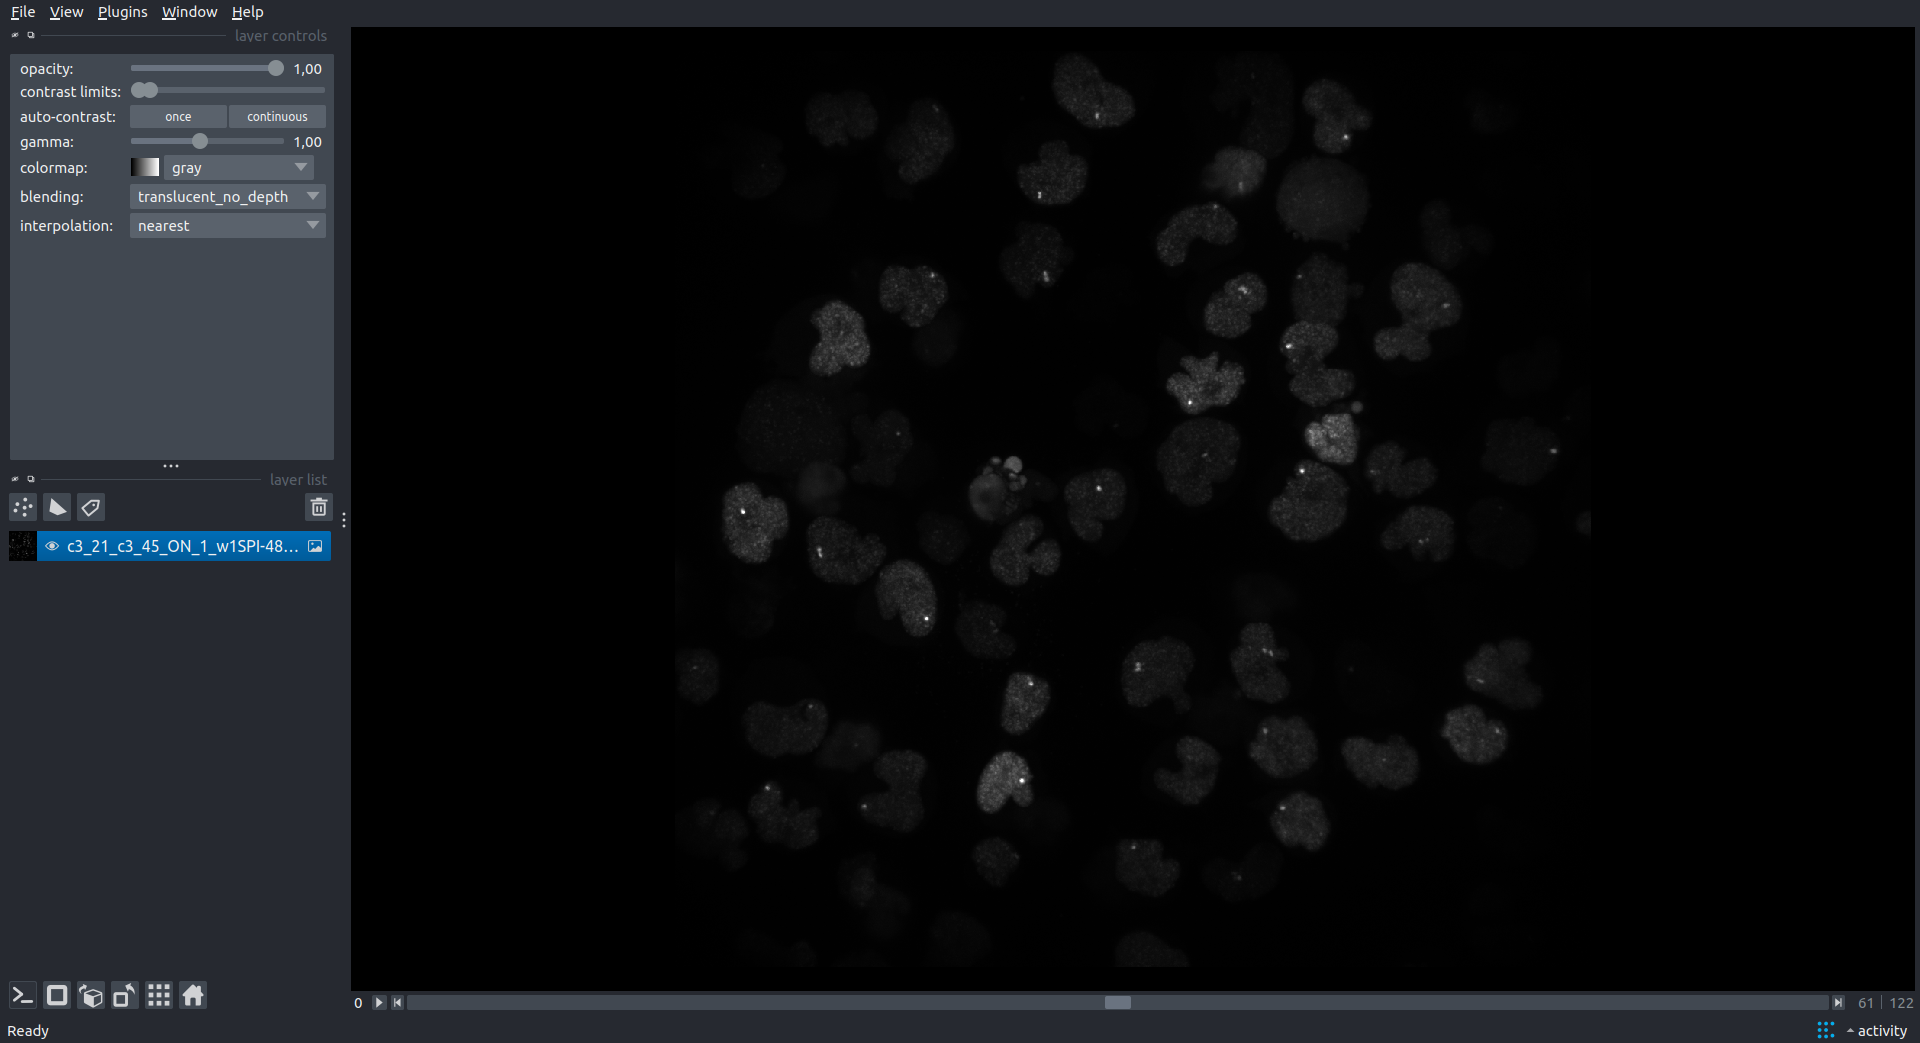

In [3]:
dataset_path = Path("/media/raphael/data/works/full_data_movie/c3_21_c3_45_ON_1_w1SPI-488_s3/MIP")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*.tif")), stack=True)

image = viewer.layers[0].data

nbscreenshot(viewer)

## 2.2 Segmentation using cellpose
You can choose the model of segmentation here : "cyto" or nuclei or modify the diameter or gamma. 

In [4]:
cellpose = Cellpose(model_type="cyto", gpu=False)

def predict(frame, gamma):
    norm_frame = normalize(np.asarray(frame), gamma=gamma)
    return cellpose(norm_frame, tile=False, normalize=False, diameter=120)

cellpose_labels = np.zeros(image.shape, dtype=np.int32)
array_apply(image, 
            out_array=cellpose_labels, 
            func=predict,
            gamma=0.5
           )

viewer.add_labels(cellpose_labels, name="cellpose")
    

Applying predict ...: 100%|███████████████████| 123/123 [32:35<00:00, 15.90s/it]


<Labels layer 'cellpose' at 0x7fe7fc37beb0>

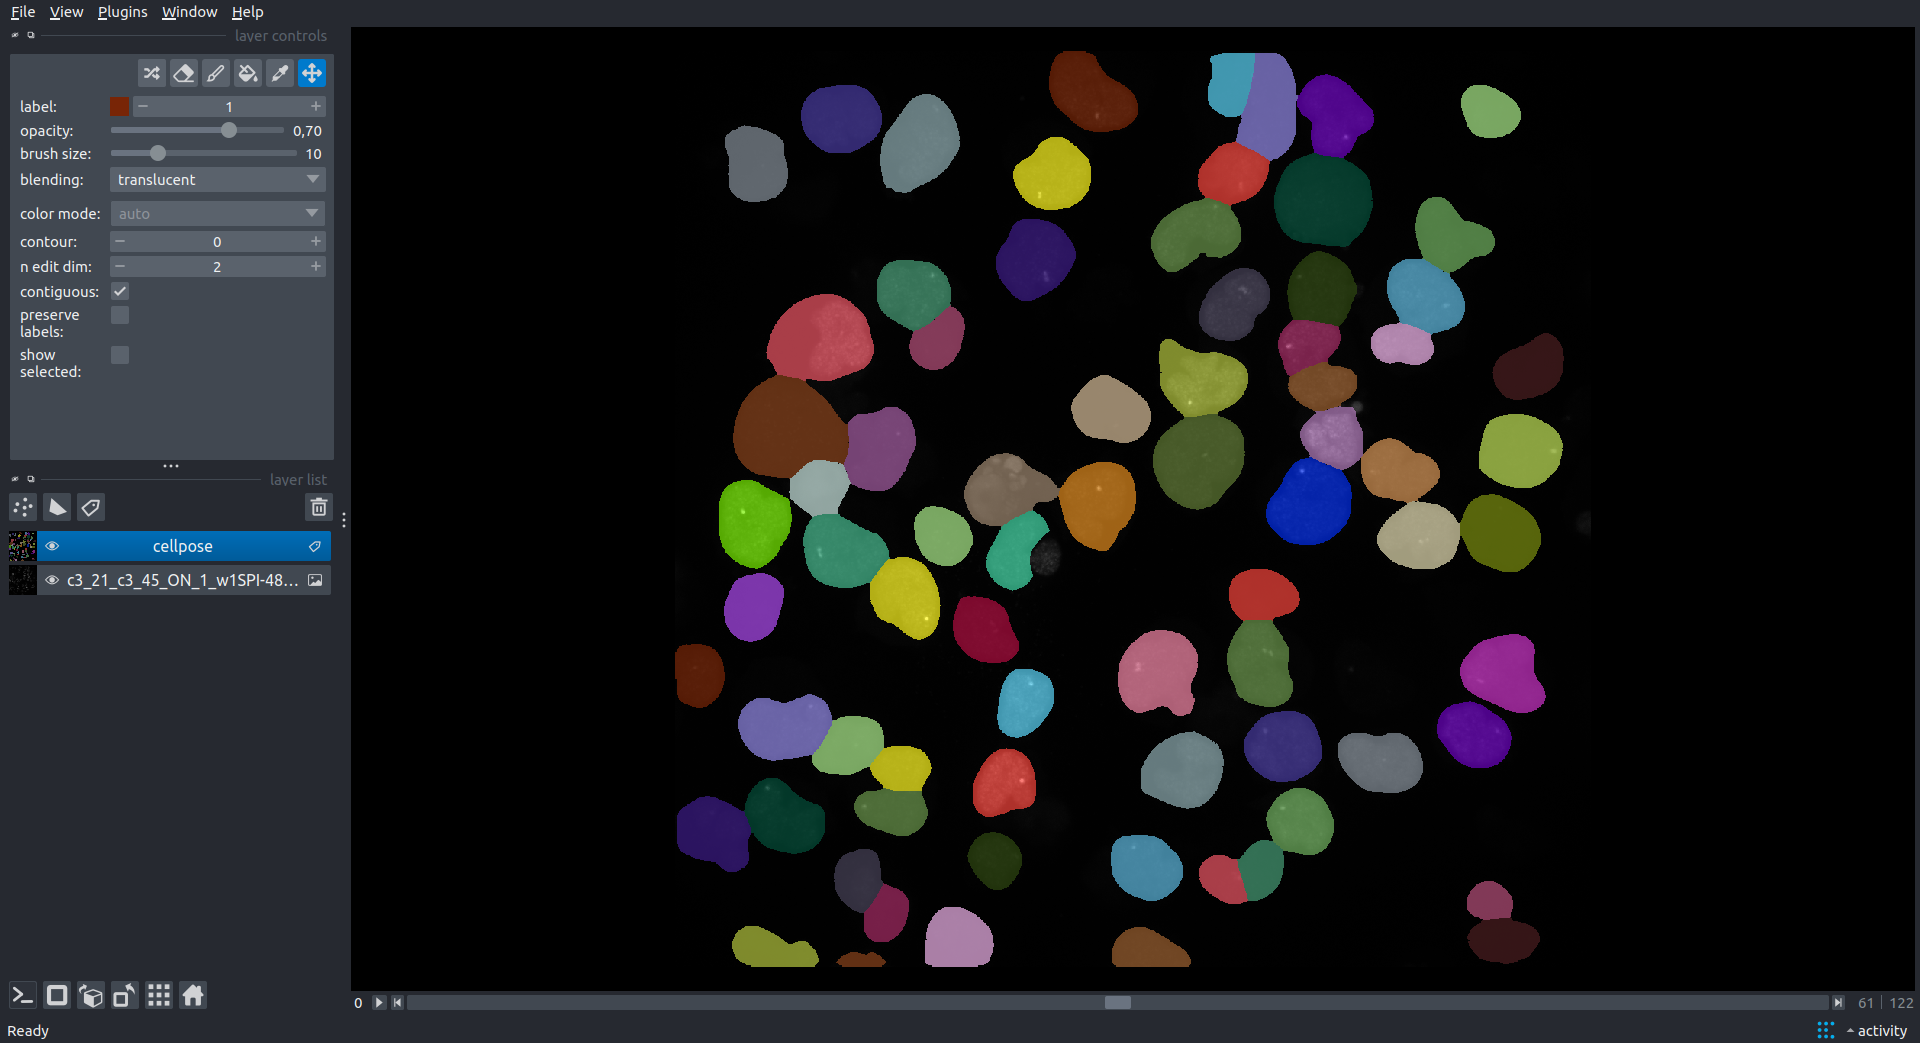

In [5]:
nbscreenshot(viewer)

In [6]:
detection, edges = labels_to_edges(cellpose_labels, sigma=4.0)  # multiple labels can be used with [labels_0, labels_1, ...]

Converting labels to edges: 100%|█████████████| 123/123 [00:14<00:00,  8.61it/s]


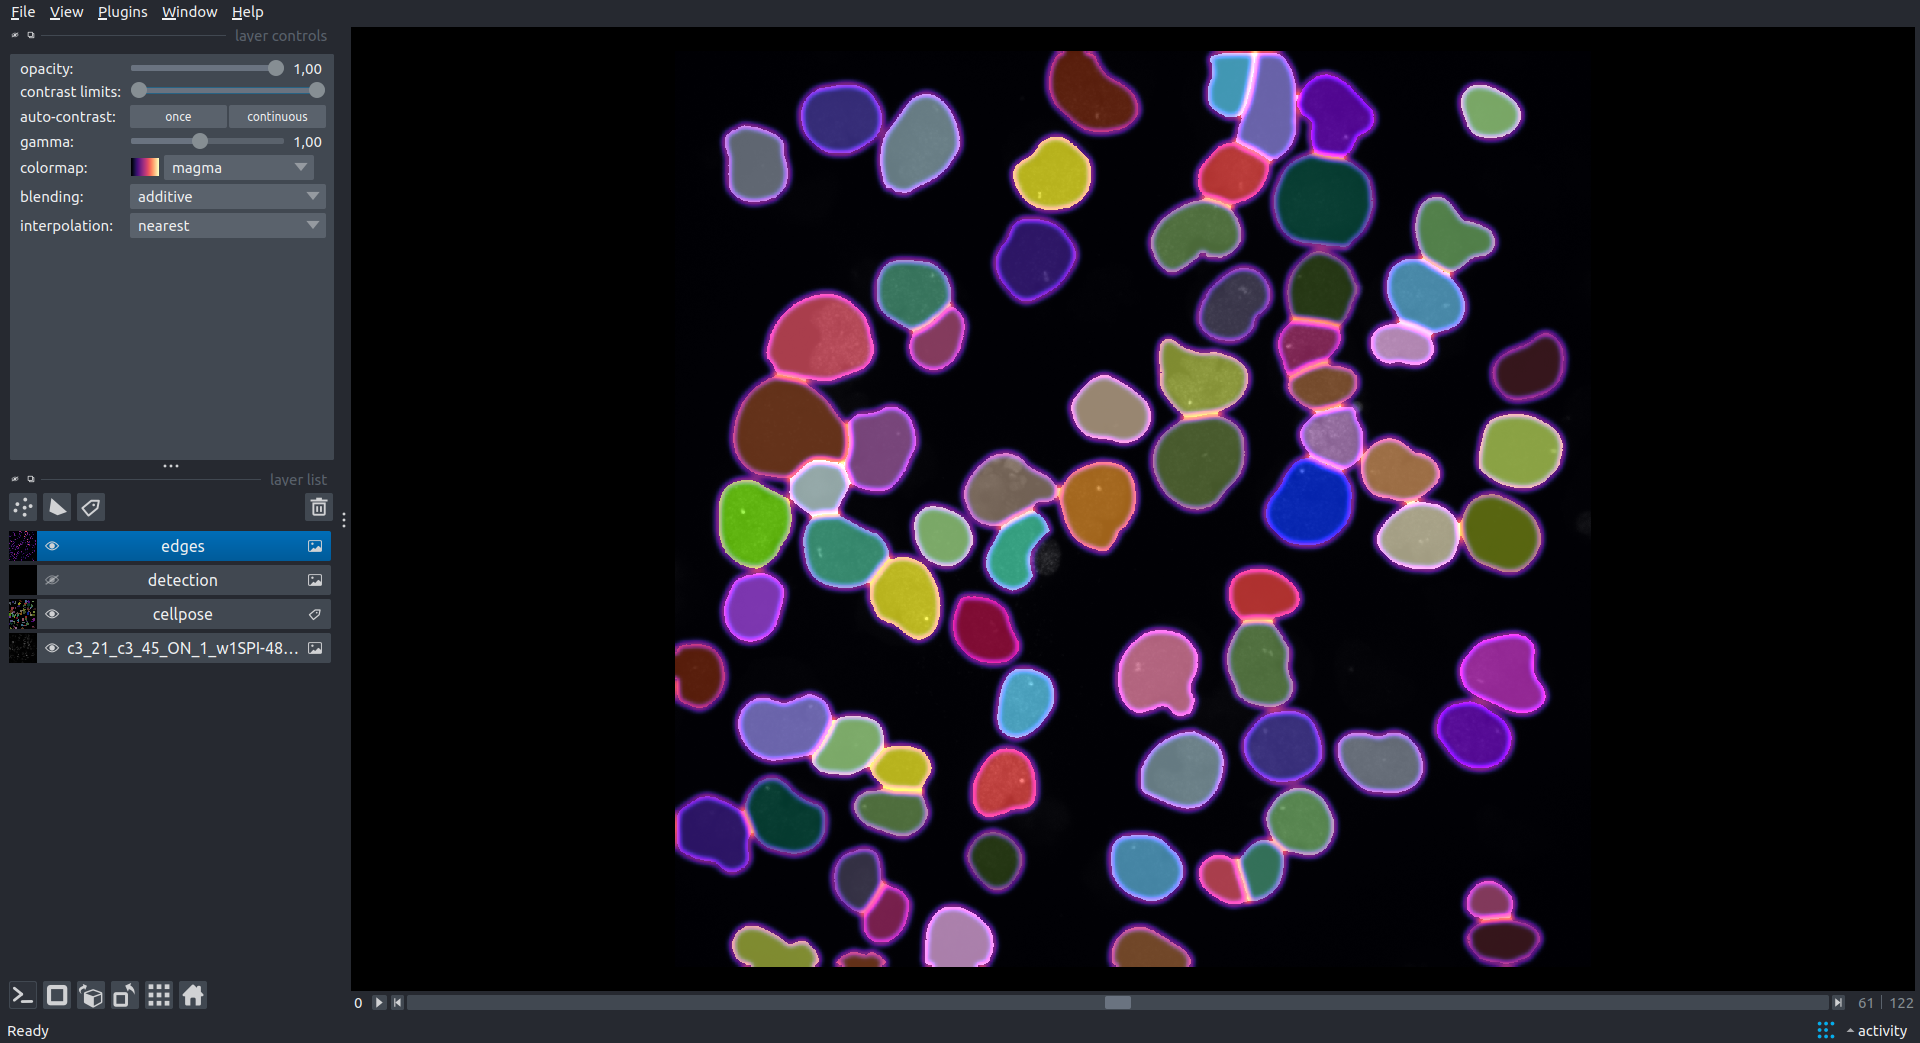

In [7]:
viewer.add_image(detection, visible=False)
viewer.add_image(edges, blending="additive", colormap="magma")
nbscreenshot(viewer)

## 2.3 Save all layers 

Here you can choose the name of the folder where the labels will be saved 

In [8]:
save_layers(cellpose_labels,'cellpose_s3')

Saving frame |████████████████████████████████████████| 123/123 [100%] in 14.0s 


In [9]:

save_layers(detection, 'detection_img_s3')

Saving frame |████████████████████████████████████████| 123/123 [100%] in 13.0s 


In [10]:
save_layers(edges, 'edges_s3')

Saving frame |████████████████████████████████████████| 123/123 [100%] in 14.7s 


In [11]:
viewer.layers[1].save('cellpose_s3.tif')
viewer.layers[3].save('edges_s3.tif')

['edges_s3.tif']